In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.shape, test_df.shape

((26370, 41), (6593, 40))

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26370 entries, 0 to 26369
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   26370 non-null  int64 
 1   Area                 26370 non-null  int64 
 2   Location             26370 non-null  object
 3   No. of Bedrooms      26370 non-null  int64 
 4   Resale               26370 non-null  int64 
 5   MaintenanceStaff     26370 non-null  int64 
 6   Gymnasium            26370 non-null  int64 
 7   SwimmingPool         26370 non-null  int64 
 8   LandscapedGardens    26370 non-null  int64 
 9   JoggingTrack         26370 non-null  int64 
 10  RainWaterHarvesting  26370 non-null  int64 
 11  IndoorGames          26370 non-null  int64 
 12  ShoppingMall         26370 non-null  int64 
 13  Intercom             26370 non-null  int64 
 14  SportsFacility       26370 non-null  int64 
 15  ATM                  26370 non-null  int64 
 16  Club

In [5]:
train_df.head()

,id,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Price
0,26813,964,Hooghly Chinsurah,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,7500000
1,10365,1075,Virar West,2,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,6200000
2,17863,2092,Manikonda,3,0,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,10400000
3,24337,1174,Devanahalli,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,18600000
4,12590,1380,Kharghar,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9500000


In [6]:
if train_df.duplicated().sum() == 0:
    print('No duplicates')
else:
    print(f'Data has {train_df.duplicated().sum()} duplicates', end=' ')
    train_df.drop_duplicates(inplace=True)
    print('and they were removed')


No duplicates


In [7]:
if train_df.duplicated(subset=['id']).sum() == 0:
    print('No duplicates in id')
    train_df.drop('id', axis=1, inplace=True)
else:
    print(f'Data has {train_df.duplicated(subset=["id"]).sum()} duplicates in id', end=' ')
    train_df.drop_duplicates(subset=['id'], inplace=True)
    print('and they were removed')

No duplicates in id


In [8]:
train_df.groupby(['Location'])['Price'].max().sort_values(ascending=False)

Location
Vasant Kunj             854599999
Sunder Nagar            854599999
Saket                   748100000
West End                704400000
Sector 4 Dwarka         654599999
                          ...    
Sector-26 Taloja          2100000
Asangaon                  2035000
Jhangir Pet               2014000
Uttar Panchanna Gram      2000000
Vasind                    2000000
Name: Price, Length: 1640, dtype: int64

## Test with Linear Regression

In [9]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

label_encoder = LabelEncoder()
train_df['Location'] = label_encoder.fit_transform(train_df['Location'])


X = train_df.drop('Price', axis=1)
y = train_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
# best model for regression: RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor, 
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'LGBM': LGBMRegressor(),
    'XGB': XGBRegressor(),
    'CatBoost': CatBoostRegressor()
}

for name, model in models.items():
    if name in ['CatBoost','LGBM']:
        model.set_params(verbose=0)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    print(f'{name} RMSE: {root_mean_squared_error(y_test, y_pred)}')
    print(f'{name} R2 score: {r2_score(y_test, y_pred)}')



Linear Regression RMSE: 19561318.136450995
Linear Regression R2 score: 0.08447593905022432
Random Forest RMSE: 19627278.07029362
Random Forest R2 score: 0.0782913129634325
LGBM RMSE: 18690779.401546206
LGBM R2 score: 0.16414998731249608
XGB RMSE: 20281913.123871926
XGB R2 score: 0.015781857891255857
CatBoost RMSE: 18721867.534949034
CatBoost R2 score: 0.16136715772440968


In [11]:
param_lgbm = {
    'num_leaves': Integer(10, 50),
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 500),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0)
}

param_xgb = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 500),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0)
}

param_cat = {
    'depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3),
    'iterations': Integer(100, 500),
    'bagging_temperature': Real(0.5, 5.0),
    'l2_leaf_reg': Real(1, 5)
}


np.int = int
opt_lgbm = BayesSearchCV(
    LGBMRegressor(),
    param_lgbm,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

opt_xgb = BayesSearchCV(
    XGBRegressor(),
    param_xgb,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

opt_cat = BayesSearchCV(
    CatBoostRegressor(),
    param_cat,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

opt_models = {
    'LGBM': opt_lgbm,
    'XGB': opt_xgb,
    'CatBoost': opt_cat
}

for name, model in opt_models.items():
    model.set_params(verbose=0)
    model.fit(X_train_scaled, y_train)
    print(f'{name} r2: {model.best_score_}')
    for param, value in model.best_params_.items():
        print(f'{param}: {value}')
    print()

c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 21096, number of used features: 39
[LightGBM] [Info] Start training from score 11612606.009291
LGBM r2: -22058504.733188085
colsample_bytree: 1.0
learning_rate: 0.01
n_estimators: 500
num_leaves: 10
subsample: 1.0

XGB r2: -22050683.019188117
colsample_bytree: 0.886002695018005
learning_rate: 0.14437131208149917
max_depth: 3
n_estimators: 100
subsample: 1.0

0:	learn: 23319516.0868159	total: 21.6ms	remaining: 2.13s
1:	learn: 23137089.7741414	total: 27.7ms	remaining: 1.36s
2:	learn: 22972528.0509834	total: 33.5ms	remaining: 1.08s
3:	learn: 22840771.1040565	total: 39.1ms	remaining: 939ms
4:	learn: 22703614.8300296	total: 44.8ms	remaining: 852ms
5:	learn: 22563808.2328166	total: 50.3ms	remaining: 788ms
6:	learn: 22484362.4364980	total: 56ms

In [12]:
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

X_combined = scaler.fit_transform(X_combined)

opt_lgbm.best_estimator_.fit(X_combined, y_combined)
opt_xgb.best_estimator_.fit(X_combined, y_combined)
opt_cat.best_estimator_.fit(X_combined, y_combined)

rmse_test = {}
r2_test = {}
for name, model in opt_models.items():
    model.set_params(verbose=0)
    y_pred = model.best_estimator_.predict(X_test_scaled)
    rmse_test[name] = root_mean_squared_error(y_test, y_pred)
    r2_test[name] = r2_score(y_test, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 26370, number of used features: 39
[LightGBM] [Info] Start training from score 11627497.808343
0:	learn: 22742721.6388124	total: 4.87ms	remaining: 482ms
1:	learn: 22556350.6792507	total: 10.1ms	remaining: 494ms
2:	learn: 22406004.9371548	total: 14.3ms	remaining: 462ms
3:	learn: 22286816.8649399	total: 18.7ms	remaining: 449ms
4:	learn: 22159318.7682163	total: 23.3ms	remaining: 443ms
5:	learn: 22049164.7122252	total: 28.4ms	remaining: 445ms
6:	learn: 21935439.3308022	total: 32ms	remaining: 426ms
7:	learn: 21830131.9836904	total: 37ms	remaining: 425ms
8:	learn: 21764680.7525381	total: 41.4ms	remaining: 418ms
9:	learn: 21713378.8710591	total: 45.2ms	remaining: 407ms
10:	learn: 21664532.9695196	total: 49.7ms	remaining: 402ms
11:	learn: 216093

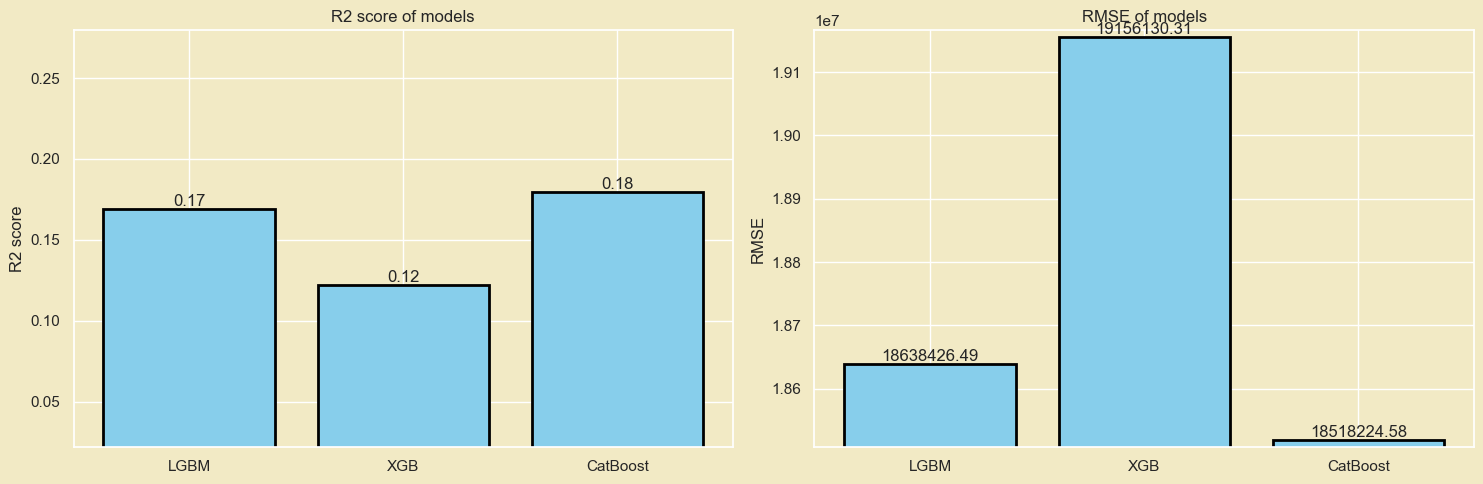

In [13]:
categories = list(r2_test.keys())
r2_values = list(r2_test.values())
rmse_test_values = list(rmse_test.values())

indices = np.arange(len(categories))

sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

bars1 = ax[0].bar(indices, r2_values, color='skyblue', edgecolor='black', linewidth=2)
ax[0].set_ylabel('R2 score')
ax[0].set_xticks(indices)
ax[0].set_xticklabels(categories)
ax[0].set_title('R2 score of models')
ax[0].set_ylim(min(r2_values) - 0.1, max(r2_values) + 0.1)
ax[0].bar_label(bars1, fmt='%.2f')

bars2 = ax[1].bar(indices, rmse_test_values, color='skyblue', edgecolor='black', linewidth=2)
ax[1].set_ylabel('RMSE')
ax[1].set_xticks(indices)
ax[1].set_xticklabels(categories)
ax[1].set_title('RMSE of models')
ax[1].set_ylim(min(rmse_test_values) - 10000, max(rmse_test_values) + 10000)
ax[1].bar_label(bars2, fmt='%.2f')

plt.tight_layout()
plt.show()

In [15]:
real_test_df = test_df.copy()
unseen_labels = set(real_test_df['Location']) - set(label_encoder.classes_)
if unseen_labels:
    label_encoder.classes_ = np.append(label_encoder.classes_, list(unseen_labels))
real_test_df['Location'] = label_encoder.transform(real_test_df['Location'])

X_real_test = real_test_df.drop('id', axis=1)
X_real_test_scaled = scaler.transform(X_real_test)
y_real_test = opt_cat.best_estimator_.predict(X_real_test_scaled)

submission = pd.DataFrame({'id': test_df['id'], 'Price': y_real_test})
submission.to_csv('submission.csv', index=False)